# 無限時間最適フィードバック制御モデル
## モデルの構造
**無限時間最適フィードバック制御モデル** (**infinite-horizon optimal feedback control model**) {cite:p}`Qian2013-zy`

$$
\begin{align}
d x&=(\mathbf{A} x+\mathbf{B} u) dt +\mathbf{Y} u d \gamma+\mathbf{G} d \omega \\
d y&=\mathbf{C} x dt+\mathbf{D} d \xi\\
d \hat{x}&=(\mathbf{A} \hat{x}+\mathbf{B} u) dt+\mathbf{K}(dy-\mathbf{C} \hat{x} dt)
\end{align}
$$

## 実装
ライブラリの読み込みと関数の定義．

In [1]:
using Parameters: @unpack
using LinearAlgebra, Kronecker, Random, BlockDiagonals, PyPlot
rc("axes.spines", top=false, right=false)
rc("font", family="Arial") 

定数の定義

$$
\begin{align}
\alpha_{1}&=\frac{b}{t_{a} t_{e} I},\quad \alpha_{2}=\frac{1}{t_{a} t_{e}}+\left(\frac{1}{t_{a}}+\frac{1}{t_{e}}\right) \frac{b}{I} \\
\alpha_{3}&=\frac{b}{I}+\frac{1}{t_{a}}+\frac{1}{t_{e}},\quad b_{u}=\frac{1}{t_{a} t_{e} I}
\end{align}
$$

In [2]:
@kwdef struct SaccadeModelParameter
    n = 4 # number of dims
    i = 0.25 # kgm^2, 
    b = 0.2 # kgm^2/s
    ta = 0.03 # s
    te = 0.04 # s
    L0 = 0.35 # m

    bu = 1 / (ta * te * i)
    α1 = bu * b
    α2 = 1/(ta * te) + (1/ta + 1/te) * b/i
    α3 = b/i + 1/ta + 1/te

    A = [zeros(3) I(3); -[0, α1, α2, α3]']
    B = [zeros(3); bu]
    C = [I(3) zeros(3)]
    D = Diagonal([1e-3, 1e-2, 5e-2])

    Y = 0.02 * B
    G = 0.03 * I(n)

    Q = Diagonal([1.0, 0.01, 0, 0]) 
    R = 0.0001
    U = Diagonal([1.0, 0.1, 0.01, 0])
end

SaccadeModelParameter

$$
\begin{align}
\mathbf{X}:=\begin{bmatrix}
x \\
\tilde{x}
\end{bmatrix}, d \bar{\omega} :=\begin{bmatrix}
d \omega \\
d \xi
\end{bmatrix}, \bar{\mathbf{A}} :=\begin{bmatrix}
\mathbf{A}-\mathbf{B} \mathbf{L} & \mathbf{B} \mathbf{L} \\
\mathbf{0} & \mathbf{A}-\mathbf{K} \mathbf{C}
\end{bmatrix}\\
\bar{\mathbf{Y}} :=\begin{bmatrix}
-\mathbf{Y} \mathbf{L} & \mathbf{Y} \mathbf{L} \\
-\mathbf{Y} \mathbf{L} & \mathbf{Y} \mathbf{L}
\end{bmatrix}, \bar{G} :=\begin{bmatrix}
\mathbf{G} & \mathbf{0} \\
\mathbf{G} & -\mathbf{K} \mathbf{D}
\end{bmatrix}
\end{align}
$$

とする．元論文では$F, \bar{F}$が定義されていたが，$F=0$とするため，以後の式から削除した．

$$
\begin{align}
\mathbf{P} &:=\begin{bmatrix}
\mathbf{P}_{11} & \mathbf{P}_{12} \\
\mathbf{P}_{12} & \mathbf{P}_{22}
\end{bmatrix} = \mathbb{E}\left[\mathbf{X} \mathbf{X}^\top\right] \\
\mathbf{V} &:=\begin{bmatrix}
\mathbf{Q}+\mathbf{L}^\top R \mathbf{L} & -\mathbf{L}^\top R \mathbf{L} \\
-\mathbf{L}^\top R \mathbf{L} & \mathbf{L}^\top R \mathbf{L}+\mathbf{U}
\end{bmatrix}
\end{align}
$$

aaa
$$
\begin{align}
&K=\mathbf{P}_{22} \mathbf{C}^\top\left(\mathbf{D} \mathbf{D}^\top\right)^{-1} \\
&\mathbf{L}=\left(R+\mathbf{Y}^\top\left(\mathbf{S}_{11}+\mathbf{S}_{22}\right) \mathbf{Y}\right)^{-1} \mathbf{B}^\top \mathbf{S}_{11} \\
&\bar{\mathbf{A}}^\top \mathbf{S}+\mathbf{S} \bar{\mathbf{A}}+\bar{\mathbf{Y}}^\top \mathbf{S} \bar{\mathbf{Y}}+\mathbf{V}=0 \\
&\bar{\mathbf{A}} \mathbf{P}+\mathbf{P} \bar{\mathbf{A}}^\top+\bar{\mathbf{Y}} \mathbf{P} \bar{\mathbf{Y}}^\top+\bar{\mathbf{G}} \bar{\mathbf{G}}^\top=0
\end{align}
$$


$\mathbf{A} = (a_{ij})$ を $m \times n$ 行列，$\mathbf{B} = (b_{kl})$ を $p \times q$ 行列とすると、それらのクロネッカー積 $\mathbf{A} \otimes \mathbf{B}$ は

$$
\begin{equation}
\mathbf{A}\otimes \mathbf{B}={\begin{bmatrix}a_{11}\mathbf{B}&\cdots &a_{1n}\mathbf{B}\\\vdots &\ddots &\vdots \\a_{m1}\mathbf{B}&\cdots &a_{mn}\mathbf{B}\end{bmatrix}}
\end{equation}
$$

で与えられる $mp \times nq$ 区分行列である．

Roth's column lemma (vec-trick) 

$$
\begin{equation}
(\mathbf{B}^\top \otimes \mathbf{A})\text{vec}(\mathbf{X}) = \text{vec}(\mathbf{A}\mathbf{X}\mathbf{B})=\text{vec}(\mathbf{C})
\end{equation}
$$

によりこれを解くと，

$$
\begin{align}
\mathbf{S} &= -\text{vec}^{-1}\left(\left(\mathbf{I} \otimes \bar{\mathbf{A}}^\top + \bar{\mathbf{A}}^\top \otimes \mathbf{I} + \bar{\mathbf{Y}}^\top \otimes \bar{\mathbf{Y}}^\top\right)^{-1}\text{vec}(\mathbf{V})\right)\\
\mathbf{P} &= -\text{vec}^{-1}\left(\left(\mathbf{I} \otimes \bar{\mathbf{A}} + \bar{\mathbf{A}} \otimes \mathbf{I} + \bar{\mathbf{Y}} \otimes \bar{\mathbf{Y}}\right)^{-1}\text{vec}(\bar{\mathbf{G}}\bar{\mathbf{G}}^\top)\right)
\end{align}
$$

となる．ここで$\mathbf{I}=\mathbf{I}^\top$を用いた．

### K, L, S, Pの計算
K, L, S, Pの計算は次のようにする．
1. LとKをランダムに初期化
1. SとPを計算
1. LとKを更新
1. 収束するまで2と3を繰り返す．

収束スピードはかなり速い．

In [3]:
using ProgressMeter

In [4]:
param = SaccadeModelParameter();

### シミュレーション
関数を書く．

In [ ]:
##### function simulation(param::SaccadeModelParameter, L, dt=0.001, T=2.0, init_pos=-0.5)
    @unpack n, A, B, C, D, Y, G, Q, R, U = param
    nt = round(Int, T/dt)
    X = zeros(n, nt)
    u = zeros(nt)
    c = zeros(nt)
    z = zeros(n, nt)
    X[1, 1] = init_pos # m; initial position (target position is zero)
    sqrtdt = √dt
    for t in 1:nt-1
        xi = 0.01*randn()
        u[t] = -L * X[:, t] + xi
        z[:, t+1] = z[:, t] .+ xi .* X[:, t]
        c[t] = X[:, t]' * Q * X[:, t] + R * u[t]^2
        X[:, t+1] = X[:,t] + (A * X[:,t] + B * u[t]) * dt #+ sqrtdt * (Y * u[t] * randn() + G * randn(n))
    end
    return X, u, z, c
end

In [161]:
dt = 1e-3
T = 1.0
n = 4
η = 5e-5

FW = rand(n);# .- 0.5;
num_iter = 2000

2000

In [146]:
nt = round(Int, T/dt)

1000

In [162]:
error_arr = zeros(num_iter);

L = 1e-2*randn(n)';
G = zeros(n)'
X_ = nothing
@showprogress for i in 1:num_iter
    X, u, z, c = simulation(param::SaccadeModelParameter, L, dt, T)
    Z = η * (z*c)'
    G = 0.9 * G + 0.1*Z
    L = L - G
    error_arr[i] = sum(c) / nt
    if i == num_iter
        X_ = X
    end
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


In [163]:
L

1×4 adjoint(::Vector{Float64}) with eltype Float64:
 -0.0549891  -0.00879025  -0.00562452  -0.0084761

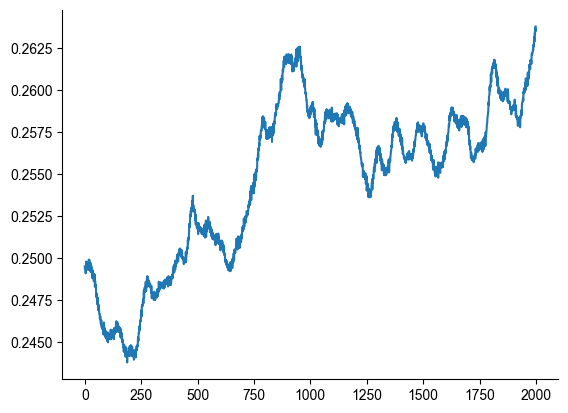

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001D94678B260>

In [164]:
plot(error_arr)

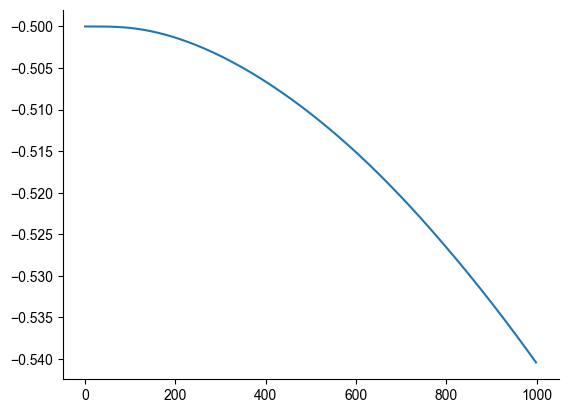

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001D946859DF0>

In [165]:
plot(X_[1, :])